In [1]:
import GCRCatalogs
from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs
import clevar
clevar.__version__

'0.13.5'

In [2]:
import sys
sys.path.append('../')
from cluster_validation.mass_richness_functions import *


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 

matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'figure.figsize': (10,8)})

In [4]:
#import emcee
#import corner

# 1 - opening catalogs

In [4]:
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image' )

In [5]:
cosmo = gc_truth.cosmology

In [6]:
min_richness = 5
min_halo_mass = 1e13 #Msun

### match with MFoF definition

In [7]:
RM_cat = ClCatalog.read('RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True)

In [8]:
halo_cat = ClCatalog.read('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True)

In [9]:
RM_cat.read_members('RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)

In [10]:
halo_cat.read_members('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

### match with M200c definition

In [11]:
#RM_cat = ClCatalog.read('../v0/c1.fits', name='RM_cat', full=True)

In [12]:
#halo_cat = ClCatalog.read('../v0/c2.fits', name='halo_cat', full=True)

# 2 - associate redMaPPer detections to true DC2 halos

In [13]:
RM_cat._init_match_vals(True)
halo_cat._init_match_vals(True)

In [14]:
mt = MembershipMatch()

In [15]:
mt.load_matches(RM_cat, halo_cat, out_dir='cosmoDC2_RM_match_cross_membership')

RM_cat
    * ClEvar used in matching: 0.13.5
 * Total objects:    45,081
 * multiple (self):  43,211
 * multiple (other): 43,211
 * unique (self):    42,973
 * unique (other):   42,825
 * cross:            42,754

halo_cat
    * ClEvar used in matching: 0.13.5
 * Total objects:    278,904
 * multiple (self):  75,514
 * multiple (other): 75,514
 * unique (self):    42,825
 * unique (other):   42,973
 * cross:            42,754


In [16]:
#mt.load_matches(RM_cat, halo_cat, out_dir='../v0')

In [17]:
RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

In [18]:
RM_cat_bij.size, RM_cat_bij.size/RM_cat.size,  halo_cat_bij.size/halo_cat.size

(42754, 0.9483818016459262, 0.15329288930958324)

# 3 - Analyse mass richness relation

### Comparison to DES

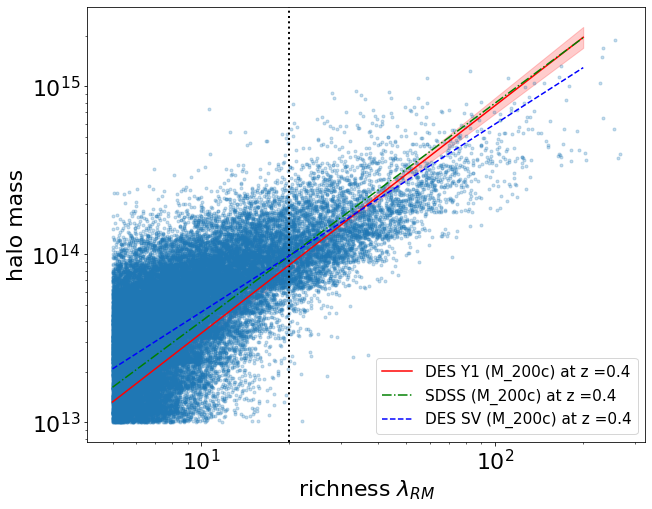

In [21]:
plt.loglog(RM_cat_bij['richness'], halo_cat_bij['mass_fof'], '.',alpha=0.25)

plt.axvline(20, color='black', linestyle='dotted', lw=2)

plt.xlabel("richness $\\lambda_{RM}$")
plt.ylabel('halo mass')


#adding parametrization from litterature
ll = np.logspace(np.log10(min_richness), np.log10(200))

z0 = 0.4
Om_z0 = cosmo.Om0   

plt.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.2,color='r')

plt.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'r-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
plt.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))

plt.legend(fontsize='x-small')

### Fit of the relation

In [58]:
from importlib import reload  # 
reload(cluster_validation.mass_richness_functions)
from cluster_validation.mass_richness_functions import *

In [37]:
data_mcmc = [np.log10(halo_cat_bij['mass_fof']), RM_cat_bij['z'], np.log10(RM_cat_bij['richness'])]

In [38]:
DES_limits =  (halo_cat_bij['z']>0.2) * (halo_cat_bij['z']<0.65) * (RM_cat_bij['richness']>20)

data_mcmc_limited = [np.log10(halo_cat_bij['mass_fof'][DES_limits]), RM_cat_bij['z'][DES_limits], np.log10(RM_cat_bij['richness'][DES_limits])]

In [50]:
initial = [14.3,0.0,1]
pos = initial + 0.5 * np.random.randn(100, len(initial))
Nit = 500
labels = [r'$\log_{10}(M_{\rm FoF,0})$', r'$G_z^\mu$', r'$G_\lambda^\mu$']
#labels = [r'$\log_{10}(M_{\rm 200c,0})$', r'$G_z^\mu$', r'$G_\lambda^\mu$']

100%|██████████| 500/500 [01:26<00:00,  5.77it/s]


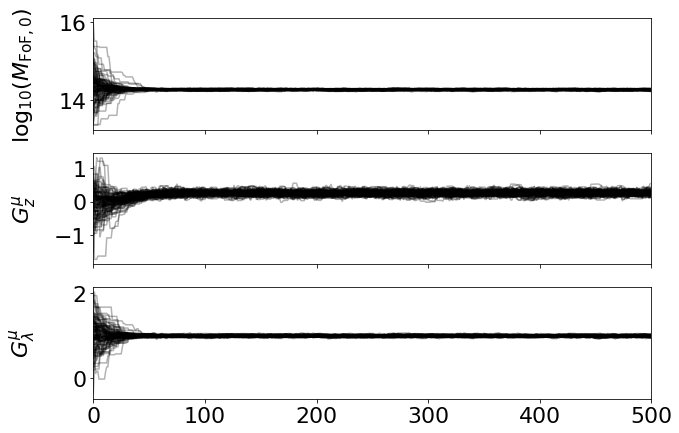

In [51]:
sampler =  sampler_prep(pos, data_mcmc)
sampler.run_mcmc(pos, Nit, progress=True);
plot_chains(labels, sampler)

100%|██████████| 500/500 [00:28<00:00, 17.61it/s]


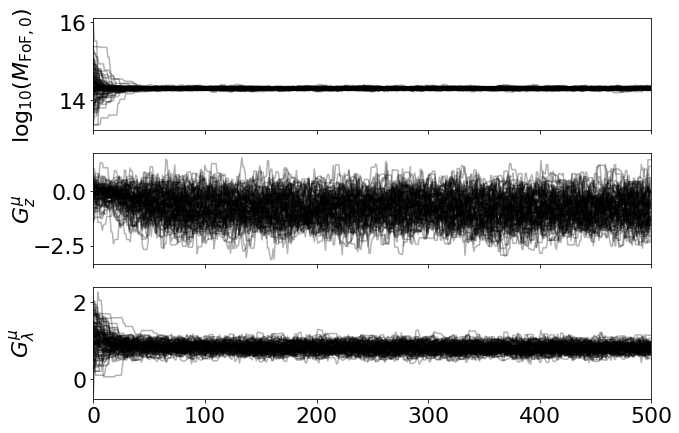

In [52]:
sampler_limited =  sampler_prep(pos, data_mcmc_limited)
sampler_limited.run_mcmc(pos, Nit, progress=True);
plot_chains(labels, sampler_limited)

In [53]:
flat_samples = sampler.get_chain(discard=150, thin=1, flat=True)
flat_samples_limited = sampler_limited.get_chain(discard=150, thin=1, flat=True)

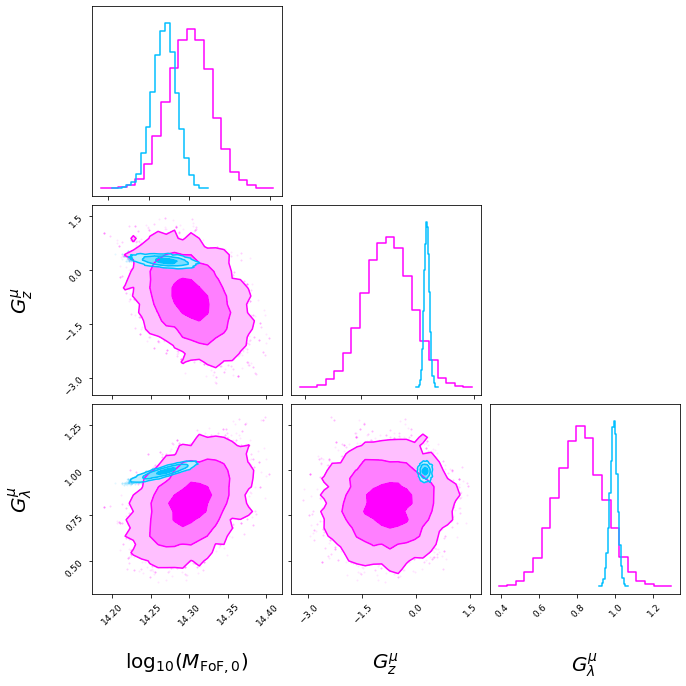

In [59]:
fig, axs = plt.subplots(len(labels), len(labels), figsize = (10,10))  
plot_corner(fig, flat_samples_limited, labels, bins =20)
plot_corner(fig, flat_samples, labels, bins =20,  color='deepskyblue')

for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 9)

In [60]:
np.mean(flat_samples,axis=0), np.median(flat_samples,axis=0)

(array([14.26944181,  0.25356295,  0.9922993 ]),
 array([14.26979252,  0.2541971 ,  0.9927565 ]))

In [61]:
np.mean(flat_samples_limited,axis=0), np.median(flat_samples_limited,axis=0)

(array([14.30075048, -0.78149644,  0.81662867]),
 array([14.30113479, -0.77870698,  0.81586315]))

In [62]:
mor_mean = 10**(mu_logM_lambda(z0, np.log10(ll), flat_samples[:,0].mean(), flat_samples[:,1].mean(), flat_samples[:,2].mean()))

In [63]:
mor_mean_limited = 10**(mu_logM_lambda(z0, np.log10(ll), flat_samples_limited[:,0].mean(), flat_samples_limited[:,1].mean(), flat_samples_limited[:,2].mean()))

In [64]:
mor_samples = np.vstack([10**(mu_logM_lambda(z0, np.log10(ll[i]), flat_samples[:,0], flat_samples[:,1], flat_samples[:,2])) for i in range(ll.size)])

In [65]:
mor_samples_limited = np.vstack([10**(mu_logM_lambda(z0, np.log10(ll[i]), flat_samples_limited[:,0], flat_samples_limited[:,1], flat_samples_limited[:,2])) for i in range(ll.size)])

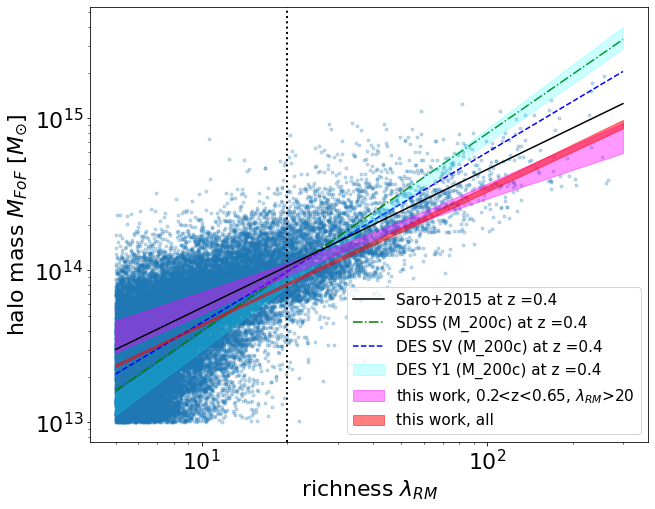

In [68]:
plt.loglog(RM_cat_bij['richness'], halo_cat_bij['mass_fof'], '.',alpha=0.25)
plt.axvline(20, color='black', linestyle='dotted', lw=2)

plt.xlabel("richness $\\lambda_{RM}$")
plt.ylabel('halo mass $M_{FoF}$ [$M_{\odot}$]')
#plt.ylabel('halo mass $M_{200,c}$ [$M_{\odot}$]')

#adding parametrization from litterature
ll = np.logspace(np.log10(min_richness), np.log10(300))

z0 = 0.4
Om_z0 = cosmo.Om0   

plt.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.2, color='cyan', zorder=3, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_Saro(ll, z0, Om_z0), 'k', alpha=1, zorder=3, label='Saro+2015 at z ='+str(z0))

#plt.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'b-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
plt.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))

#plt.plot(ll, mor_mean, lw=4)
plt.fill_between(ll, np.percentile(mor_samples_limited,16, axis=1) , np.percentile(mor_samples_limited,84, axis=1), alpha=0.4, color='magenta', zorder=3, label='this work, 0.2<z<0.65, $\\lambda_{RM}$>20')
plt.fill_between(ll, np.percentile(mor_samples,16, axis=1) , np.percentile(mor_samples,84, axis=1), alpha=0.5, color='red', zorder=3, label='this work, all')



plt.legend(fontsize='x-small')